In [1]:
import os
import json
import random
import pickle
from rdkit import Chem
import datamol as dm
import numpy as np
import tqdm
import re
import glob
from os import path as osp
import pickle
# change to where you untarred the rdkit folder
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import ast
# This enables inline rendering of molecules
IPythonConsole.ipython_useSVG=True 


In [2]:
def parse_molecule_with_coordinates(input_str):
    # Extract SMILES by removing coordinate annotations
    extracted_smiles = re.sub(r'<[^>]+>', '', input_str)
    print(extracted_smiles)
    
    # Parse the extracted SMILES
    mol = Chem.AddHs(Chem.MolFromSmiles(extracted_smiles))

    if mol is None:
        raise ValueError("Failed to parse the extracted SMILES.")
    canonical = Chem.MolToSmiles(mol, canonical=True, allHsExplicit=True)
    
    # Retrieve the atom output order from the molecule's properties
    if not mol.HasProp('_smilesAtomOutputOrder'):
        raise ValueError("SMILES atom output order not found.")
    atom_output_order = ast.literal_eval(mol.GetProp('_smilesAtomOutputOrder'))
    
    # Parse coordinates from the input string
    coords = []
    atom_pattern = re.compile(r'\[([^<]+)<([^>]+)>\]')
    for match in atom_pattern.finditer(input_str):
        coord_str = match.group(2)
        coord = list(map(float, coord_str.split(',')))
        coords.append(coord)
    
    # Verify coordinate count matches atom count
    if len(coords) != mol.GetNumAtoms():
        raise ValueError("Mismatch between number of coordinates and atoms.")
    
    # Create conformer and assign coordinates
    conf = Chem.Conformer(mol.GetNumAtoms())
    for input_idx, atom_idx in enumerate(atom_output_order):
        x, y, z = coords[input_idx]
        conf.SetAtomPosition(atom_idx, Chem.rdGeometry.Point3D(x, y, z))
    mol.AddConformer(conf)
    
    return mol

In [3]:
# base_path = "/mnt/sxtn2/chem/GEOM_data"
base_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
drugs_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs"
drugs_file = os.path.join(base_path, "summary_drugs.json")
with open(drugs_file, "r") as f:
    drugs_summ = json.load(f)

# qm9_file = os.path.join(base_path, "summary_qm9.json")
# with open(qm9_file, "r") as f:
#     qm9_summ = json.load(f)

# # data info from GeoMol
# geomol_path = "/mnt/sxtn2/chem/GEOM_data/GeoMol/data/DRUGS"
# train_indices, val_indices, _ = np.load(geomol_path + '/splits/split0.npy', allow_pickle=True)
# train_smiles, val_smiles, _ = np.load(geomol_path + '/smiles_splits/split0.npy', allow_pickle=True)

# data info from ET-Flow
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/DRUGS/"
# train_indices = np.load(indices_path + "train_indices.npy", allow_pickle=True)
# val_indices = np.load(indices_path + "val_indices.npy", allow_pickle=True)
# count = np.load(indices_path + "count_indices.npy", allow_pickle=True)

In [4]:
from rdkit import Chem

def embed_coordinates(mol, smiles):
    # Get the atom output order from the molecule
    order = list(map(int, mol.GetProp('_smilesAtomOutputOrder').split(',')))
    
    # Get the conformer's positionsconf
    conf = mol.GetConformer()
    
    # Split the SMILES into tokens
    tokens = []
    i = 0
    n = len(smiles)
    while i < n:
        if smiles[i] == '[':
            # Parse bracketed atom
            j = i + 1
            while j < n and smiles[j] != ']':
                j += 1
            if j >= n:
                j = n - 1
            tokens.append(('atom', smiles[i:j+1]))
            i = j + 1
        elif smiles[i] in {'-', '=', '#', ':', '/', '\\'}:
            # Bond symbols
            tokens.append(('bond', smiles[i]))
            i += 1
        elif smiles[i].isdigit() or smiles[i] == '%':
            # Handle ring numbers
            if smiles[i] == '%':
                if i + 2 < n and smiles[i+1].isdigit() and smiles[i+2].isdigit():
                    tokens.append(('ring', smiles[i:i+3]))
                    i += 3
                else:
                    tokens.append(('ring', smiles[i]))
                    i += 1
            else:
                j = i
                while j < n and smiles[j].isdigit():
                    j += 1
                tokens.append(('ring', smiles[i:j]))
                i = j
        elif smiles[i] in {'(', ')'}:
            # Branch
            tokens.append(('branch', smiles[i]))
            i += 1
        elif smiles[i].isupper() or smiles[i].islower():
            # Element symbol followed by optional digits
            start = i
            # Parse element
            if smiles[i].isupper() and i + 1 < n and smiles[i+1].islower():
                i += 2
            else:
                i += 1
            # Parse digits
            while i < n and smiles[i].isdigit():
                i += 1
            tokens.append(('atom', smiles[start:i]))
        else:
            # Unknown character, skip
            i += 1
    
    # Extract atom tokens and validate count
    atom_tokens = [token[1] for token in tokens if token[0] == 'atom']
    if len(atom_tokens) != len(order):
        raise ValueError("Mismatch between atom tokens count and order list length.")
    
    # Generate coordinate strings for each atom in order
    coord_strings = []
    for atom_idx in order:
        pos = conf.GetAtomPosition(atom_idx)
        coord_str = f"<{pos.x:.4f},{pos.y:.4f},{pos.z:.4f}>"
        coord_strings.append(coord_str)
    
    # Replace atom tokens with embedded coordinates
    current_atom = 0
    new_tokens = []
    for token in tokens:
        if token[0] == 'atom':
            new_token = f"{token[1]}{coord_strings[current_atom]}"
            new_tokens.append(new_token)
            current_atom += 1
        else:
            new_tokens.append(token[1])
    
    # Join tokens to form the new SMILES
    embedded_smiles = ''.join(new_tokens)
    return embedded_smiles

In [5]:
# with open("/auto/home/menuab/code/3DMolGen/evaluation/results/drugs_inference_cart_1x.pi?ckle", 'rb') as f:
    # model_preds = pickle.load(f)
# print(model_preds)
base_path = "/mnt/sxtn2/chem/GEOM_data"


test_mols_path = os.path.join(base_path, "geom_processed/test_smiles_corrected.csv")
drugs_file_path = os.path.join(base_path, "rdkit_folder/summary_drugs.json")
destination_path = "./drugs_test_inference.jsonl"

with open(drugs_file_path, "r") as f:
    drugs_summ = json.load(f)

with open(test_mols_path, 'r') as f:
    print(f.readline())
    test_mols = [(m.split(',')) for m in f.readlines()]
test_data = [(m[0].strip(), int(m[1]),m[2].strip()) for m in test_mols]

# with open("/auto/home/menuab/code/3DMolGen/true_confs.pickle", 'rb') as f:
#     true_mols = pickle.load(f)

smiles,n_conformers,corrected_smiles



In [6]:
for i in range(len(test_mols)):
    geom_smiles = test_mols[i][0]
    if geom_smiles == m:
        print(f"{m=}")
        mol = dm.to_mol(geom_smiles)
        print(dm.to_smiles(mol_m))
        display(RemoveHs(mol_m))
        # mol = dm.to_mol(geom_smiles)
        # mol = Chem.AddHs(dm.to_mol(geom_smiles),
        #             addCoords=True,         
        #             explicitOnly=False,     
        #             onlyOnAtoms=None,       
        #             addResidueInfo=False)
        # display(mol)
        canonical_smiles = dm.to_smiles(mol,
                                        canonical=True,
                                        explicit_hs=True,
                                        isomeric=True)
        display(ref_mol)
        print(f'{geom_smiles=}')
        print(f'{canonical_smiles=}')
        print(f'ref_mol to smi=   {dm.to_smiles(ref_mol)}')
        print(f'ref_mol to smi=   {dm.to_smiles(ref_mol, isomeric=True, explicit_hs=True)}')
        break


NameError: name 'm' is not defined

[CH3]/[C]([NH][CH2][CH2][c]1[cH][cH][cH][cH][cH]1)=[C]1/[C](=[O])[CH2][S+]=[C]1[O-]
[CH3]/[C]([NH][CH2][CH2][c]1[cH][cH][cH][cH][cH]1)=[C]1/[C](=[O])[CH2][S+]=[C]1[O-]
[H][c]1[c]([H])[c]([H])[c]([C]([H])([H])[C]([H])([H])[N]([H])/[C](=[C]2\[C](=[O])[C]([H])([H])[S+]=[C]2[O-])[C]([H])([H])[H])[c]([H])[c]1[H]
[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]
[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]
[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]
[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H])/C(=C2\C(=O)C([H])([H])[S+]=C2[O-])C([H])([H])[H])c([H])c1[H]
C/C(NCCc1ccccc1)=C1/C(=O)C[S+]=C1[O-]


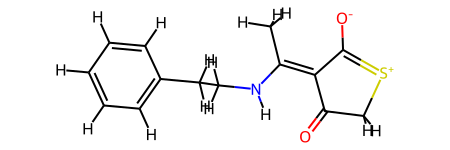

In [94]:
mol_dict = load_pkl('/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/CC(=NCCc1ccccc1)C1=C(O)CSC1=O.pickle')
confs = mol_dict["conformers"]
for conf in confs:
    mol = conf['rd_mol']
    m= 'CC(=NCCc1ccccc1)C1=C(O)CSC1=O'
    m='[CH3]/[C]([NH][CH2][CH2][c]1[cH][cH][cH][cH][cH]1)=[C]1/[C](=[O])[CH2][S+]=[C]1[O-]'
    print(m)
    print(dm.to_smiles(dm.to_mol(m),canonical=True,
                                        explicit_hs=True,
                                        isomeric=True))
    print(dm.to_smiles(Chem.AddHs(dm.to_mol(m),
                    addCoords=True,         
                    explicitOnly=False,     
                    onlyOnAtoms=None,       
                    addResidueInfo=False),
                                        canonical=True,
                                        explicit_hs=True,
                                        isomeric=True))
    print('[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]')
    print('[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]')
    print(m_gen_smiles)
    print(dm.to_smiles(mol))
    print(dm.to_smiles(RemoveHs(mol)))
    

    # print(Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False))
    # print(Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True))
    display(mol)
    break

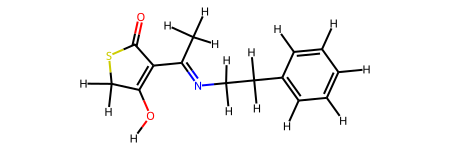

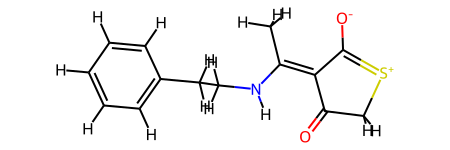

18
geom_smiles='CC(=NCCc1ccccc1)C1=C(O)CSC1=O'
geom_sm_cor='CC(=NCCc1ccccc1)C1=C(O)CSC1=O'
cor_smiles='[H][c]1[c]([H])[c]([H])[c]([C]([H])([H])[C]([H])([H])[N]([H])/[C](=[C]2\\[C](=[O])[C]([H])([H])[S+]=[C]2[O-])[C]([H])([H])[H])[c]([H])[c]1[H]'
gen_smiles='[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]'


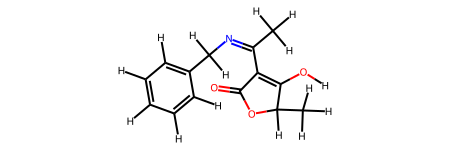

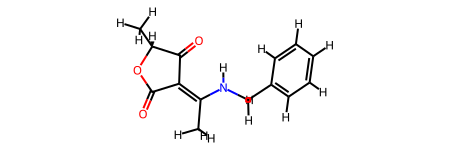

19
geom_smiles='CC(=NCc1ccccc1)C1=C(O)C(C)OC1=O'
geom_sm_cor='CC(=NCc1ccccc1)C1=C(O)C(C)OC1=O'
cor_smiles='[H][c]1[c]([H])[c]([H])[c]([C]([H])([H])[N]([H])/[C](=[C]2/[C](=[O])[O][C@]([H])([C]([H])([H])[H])[C]2=[O])[C]([H])([H])[H])[c]([H])[c]1[H]'
gen_smiles='[H][O][C]1=[C]([C](=[N][C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[O][C]1([H])[C]([H])([H])[H]'


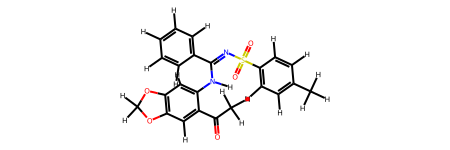

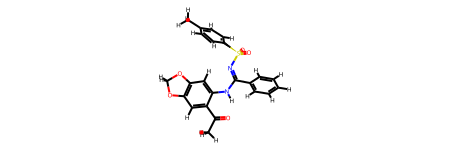

39
geom_smiles='CC(=O)c1cc2c(cc1N/C(=N/S(=O)(=O)c1ccc(C)cc1)c1ccccc1)OCO2'
geom_sm_cor='CC(=O)c1cc2c(cc1N/C(=N\\S(=O)(=O)c1ccc(C)cc1)c1ccccc1)OCO2'
cor_smiles='[H][c]1[c]([H])[c]([H])[c](/[C](=[N]\\[S](=[O])(=[O])[c]2[c]([H])[c]([H])[c]([C]([H])([H])[H])[c]([H])[c]2[H])[N]([H])[c]2[c]([H])[c]3[c]([c]([H])[c]2[C](=[O])[C]([H])([H])[H])[O][C]([H])([H])[O]3)[c]([H])[c]1[H]'
gen_smiles='[H][c]1[c]([H])[c]([H])[c](/[C](=[N]/[S](=[O])(=[O])[c]2[c]([H])[c]([H])[c]([C]([H])([H])[H])[c]([H])[c]2[H])[N]([H])[c]2[c]([H])[c]3[c]([c]([H])[c]2[C](=[O])[C]([H])([H])[H])[O][C]([H])([H])[O]3)[c]([H])[c]1[H]'


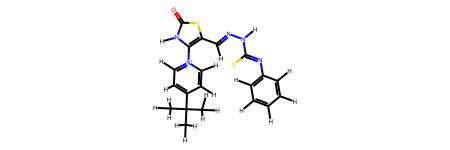

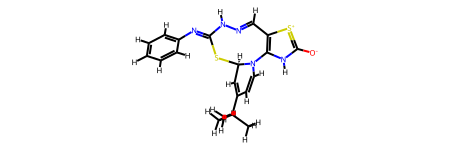

52
geom_smiles='CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1'
geom_sm_cor='CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1'
cor_smiles='[H][C]1=[C]([H])[N]2[c]3[c]([s+][c]([O-])[n]3[H])/[C]([H])=[N]/[N]([H])/[C](=[N]/[c]3[c]([H])[c]([H])[c]([H])[c]([H])[c]3[H])[S][C@]2([H])[C]([H])=[C]1[C]([C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H]'
gen_smiles='[H]/[C](=[N]\\[N]([H])[C]([S-])=[N][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H])[c]1[s][c](=[O])[n]([H])[c]1-[n+]1[c]([H])[c]([H])[c]([C]([C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])[c]([H])[c]1[H]'


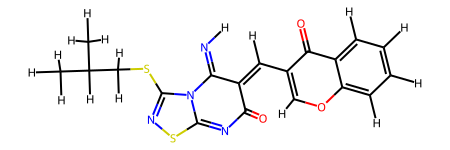

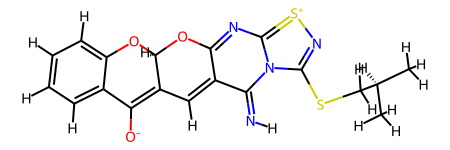

65
geom_smiles='CC(C)CSC1=NSC2=NC(=O)/C(=C\\c3coc4ccccc4c3=O)C(=N)N12'
geom_sm_cor='CC(C)CSC1=NSC2=NC(=O)/C(=C\\c3coc4ccccc4c3=O)C(=N)N12'
cor_smiles='[H]/[N]=[c]1/[c]2[c]([n][c]3[s+][n][c]([S][C]([H])([H])[C]([H])([C]([H])([H])[H])[C]([H])([H])[H])[n]13)[O][C@]1([H])[O][c]3[c]([H])[c]([H])[c]([H])[c]([H])[c]3[C]([O-])=[C]1[C]=2[H]'
gen_smiles='[H][N]=[C]1/[C](=[C](\\[H])[c]2[c]([H])[o][c]3[c]([H])[c]([H])[c]([H])[c]([H])[c]3[c]2=[O])[C](=[O])[N]=[C]2[S][N]=[C]([S][C]([H])([H])[C]([H])([C]([H])([H])[H])[C]([H])([H])[H])[N]21'


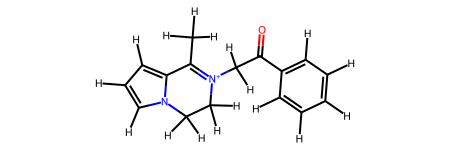

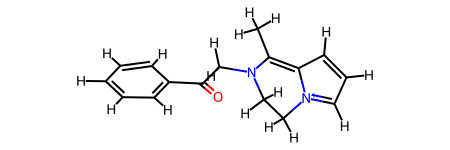

107
geom_smiles='CC1=[N+](CC(=O)c2ccccc2)CCn2cccc21'
geom_sm_cor='CC1=[N+](CC(=O)c2ccccc2)CCn2cccc21'
cor_smiles='[H][C]1=[C]([H])[C]([H])=[N+]2[C]1=[C]([C]([H])([H])[H])[N]([C]([H])([H])[C](=[O])[c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H])[C]([H])([H])[C]2([H])[H]'
gen_smiles='[H][c]1[c]([H])[c]([H])[c]([C](=[O])[C]([H])([H])[N+]2=[C]([C]([H])([H])[H])[c]3[c]([H])[c]([H])[c]([H])[n]3[C]([H])([H])[C]2([H])[H])[c]([H])[c]1[H]'
count 6


In [94]:
c = 0
faulty = []
for en, sample in enumerate(test_data):
    # print(sample[0])
    # print(drugs_summ[sample[0]]['pickle_path'])
    geom_smiles = sample[0]
    geom_sm_cor = sample[2]
    # geom_mol = dm.to_mol(geom_smiles)
    geom_mol = dm.to_mol(geom_sm_cor)
    Chem.SanitizeMol(geom_mol)
    Chem.AssignStereochemistry(geom_mol, cleanIt=True, force=True)
    geom_mol_wH = Chem.AddHs(geom_mol,
                            addCoords=True,         
                            explicitOnly=False,     
                            onlyOnAtoms=None,       
                            addResidueInfo=False)

    # Chem.SanitizeMol(geom_mol_wH)
    # Chem.AssignStereochemistry(geom_mol_wH, cleanIt=True, force=True)
    gen_smiles = dm.to_smiles(geom_mol_wH,
                                        canonical=True,
                                        explicit_hs=True,
                                        isomeric=True)
    mol_dict = load_pkl(f"/mnt/sxtn2/chem/GEOM_data/rdkit_folder/{drugs_summ[geom_smiles]['pickle_path']}")
    conf = mol_dict['conformers'][0]['rd_mol']
    cor_smiles = dm.to_smiles(conf, canonical=True, isomeric=True, explicit_hs=True)
    # rmsd = get_best_rmsd(geom_mol_wH, conf, use_alignmol=True)
    if cor_smiles != gen_smiles  :
    # if geom_smiles != geom_sm_cor:
        # display(geom_mol)
        display(geom_mol_wH)
        display(conf)
        print(en)
        # print(rmsd)
        print(f"{geom_smiles=}")
        print(f"{geom_sm_cor=}")
        # print(f"smi from con {dm.to_smiles(RemoveHs(conf, implicitOnly=False), canonical=True, isomeric=True, explicit_hs=False)}")
        print(f"{cor_smiles=}")
        print(f"{gen_smiles=}")
        c+=1
        faulty.append(en)
        if en >100:
            break
print(f"count {c}")
    
    

In [38]:
cor_smiles='[H][c]1[n][c]([N]([H])/[N]=[C]2\\[C](=[O])[N]([H])[c]3[c]([H])[c]([H])[c]([H])[c]([H])[c]32)[c]2[o][c]3[c]([H])[c]([H])[c]([H])[c]([H])[c]3[c]2[n]1'
gen_smiles='[H][O][c]1[c]([N]=[N][c]2[n][c]([H])[n][c]3[c]2[o][c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]23)[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[n]1[H]'
geom_sm_cor='Oc1[nH]c2ccccc2c1N=Nc1ncnc2c1oc1ccccc12'


In [39]:
Chem.MolToSmiles(dm.to_mol(geom_sm_cor), isomericSmiles=True, kekuleSmiles=True, allHsExplicit=True)

'[OH][C]1=[C]([N]=[N][C]2=[N][CH]=[N][C]3=[C]2[O][C]2=[CH][CH]=[CH][CH]=[C]23)[C]2=[CH][CH]=[CH][CH]=[C]2[NH]1'

In [40]:
def stupify(input_):
    if type(input_) == str:
        mol = Chem.MolFromSmiles(input_)
        Chem.AllChem.EmbedMolecule(mol, randomSeed=423)
    else:
        mol = input_
    cleaned = Chem.MolStandardize.rdMolStandardize.Cleanup(mol)
    nr = Chem.MolStandardize.rdMolStandardize.Normalizer()
    normalized = nr.normalize(cleaned)
    ri = Chem.MolStandardize.rdMolStandardize.Reionizer()
    reionized = ri.reionize(normalized)
    # if type(input_) == str:
    te = Chem.MolStandardize.rdMolStandardize.TautomerEnumerator()
    enumerated = te.Canonicalize(reionized)
    return enumerated

[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]
[H][c]1[c]([H])[c]([H])[c]([C]([H])([H])[C]([H])([H])[N]([H])/[C](=[C]2\[C](=[O])[C]([H])([H])[S+]=[C]2[O-])[C]([H])([H])[H])[c]([H])[c]1[H]


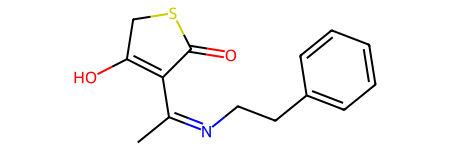

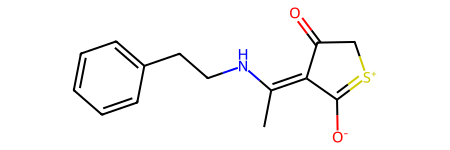

In [52]:
from rdkit.Chem.MolStandardize import rdMolStandardize
smiles1 = 'CC(=NCCc1ccccc1)C1=C(O)CSC1=O'  # First SMILES (keto form)
# smiles2 = "Oc1[nH]c2ccccc2c1N=Nc1ncnc2c1oc1ccccc12"  # Second SMILES (enol form)
# smiles1 = Chem.MolToSmiles(, canonical=True, isomericSmiles=False, allHsExplicit=True)
conf = true_mols[smiles1][0]
smiles1 = dm.to_smiles(Chem.AddHs(dm.to_mol(smiles1)), canonical=True, isomeric=True, explicit_hs=True)
smiles2 = dm.to_smiles(conf, canonical=True, isomeric=True, explicit_hs=True)
print(smiles1)
print(smiles2)
params = Chem.SmilesParserParams()
params.removeHs = False
params.skipCleanup = True
params.sanitize = False
mol1 = Chem.MolFromSmiles(smiles1)
mol2 = Chem.MolFromSmiles(smiles2)
display(mol1)
display(mol2)
tautomer_enum = rdMolStandardize.TautomerEnumerator()
taut1 = tautomer_enum.Canonicalize(mol1)
taut2 = tautomer_enum.Canonicalize(mol2)
# display(taut1)
# display(taut2)
# print(Chem.MolToSmiles(taut1))
# print(Chem.MolToSmiles(taut2))



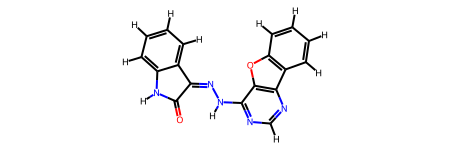

In [218]:
conf

In [54]:
smiles_from_csv ='Oc1[nH]c2ccccc2c1N=Nc1ncnc2c1oc1ccccc12'
stupified_mol_from_smiles = stupify(smiles_1)
stupified_mol_from_smiles

NameError: name 'smiles_1' is not defined

[20:23:28] Initializing MetalDisconnector
[20:23:28] Running MetalDisconnector
[20:23:28] Initializing Normalizer
[20:23:28] Running Normalizer
[20:23:28] Initializing Normalizer
[20:23:28] Running Normalizer


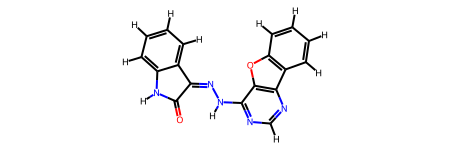

In [216]:
mol_dict = load_pkl(f"/mnt/sxtn2/chem/GEOM_data/rdkit_folder/{drugs_summ[geom_sm_cor]['pickle_path']}")
conf = mol_dict['conformers'][0]['rd_mol']
stupified_conf = stupify(conf)
conf


In [234]:
dm.to_smiles(RemoveHs(conf), canonical=True, isomeric=False)

'O=C1Nc2ccccc2C1=NNc1ncnc2c1oc1ccccc12'

In [192]:
get_best_rmsd(stupified_conf, conf)

nan

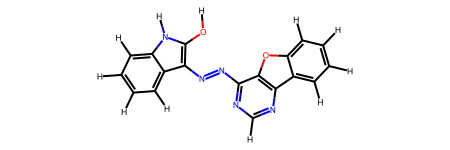

In [87]:
Chem.AddHs(te.Canonicalize(RemoveHs(mol)))

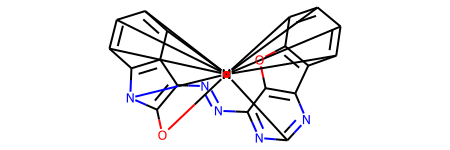

In [88]:
Chem.AddHs(te.Canonicalize(RemoveHs(conf)))

In [85]:
get_best_rmsd(te.Canonicalize(RemoveHs(mol)), te.Canonicalize(RemoveHs(conf)))

nan

In [112]:
drugs_test = []
for i in range(len(test_mols)):
    try:
        geom_smiles = test_mols[i][0]
        mol = dm.to_mol(geom_smiles)
        mol = Chem.AddHs(dm.to_mol(geom_smiles),
                 addCoords=True,         
                 explicitOnly=False,     
                 onlyOnAtoms=None,       
                 addResidueInfo=False)
        canonical_smiles = dm.to_smiles(geom_smiles,
                                        canonical=True,
                                        explicit_hs=True,
                                        isomeric=True)
        print(f'{canonical_smiles=}')
        print(f'{geom_smiles=}')
        dict_ = {
            "geom_smiles": geom_smiles,
            "num_confs": test_mols[i][1],
            "pickle_path": drugs_summ[test_mols[i][1]]['pickle_path'],
            "canonical_smiles": canonical_smiles
        }
        drugs_test.append(dict_)
    except:
        print(i , '---')

0 ---
1 ---
2 ---
3 ---
4 ---
5 ---
6 ---
7 ---
8 ---
9 ---
10 ---
11 ---
12 ---
13 ---
14 ---
15 ---
16 ---
17 ---
18 ---
19 ---
20 ---
21 ---
22 ---
23 ---
24 ---
25 ---
26 ---
27 ---
28 ---
29 ---
30 ---
31 ---
32 ---
33 ---
34 ---
35 ---
36 ---
37 ---
38 ---
39 ---
40 ---
41 ---
42 ---
43 ---
44 ---
45 ---
46 ---
47 ---
48 ---
49 ---
50 ---
51 ---
52 ---
53 ---
54 ---
55 ---
56 ---
57 ---
58 ---
59 ---
60 ---
61 ---
62 ---
63 ---
64 ---
65 ---
66 ---
67 ---
68 ---
69 ---
70 ---
71 ---
72 ---
73 ---
74 ---
75 ---
76 ---
77 ---
78 ---
79 ---
80 ---
81 ---
82 ---
83 ---
84 ---
85 ---
86 ---
87 ---
88 ---
89 ---
90 ---
91 ---
92 ---
93 ---
94 ---
95 ---
96 ---
97 ---
98 ---
99 ---
100 ---
101 ---
102 ---
103 ---
104 ---
105 ---
106 ---
107 ---
108 ---
109 ---
110 ---
111 ---
112 ---
113 ---
114 ---
115 ---
116 ---
117 ---
118 ---
119 ---
120 ---
121 ---
122 ---
123 ---
124 ---
125 ---
126 ---
127 ---
128 ---
129 ---
130 ---
131 ---
132 ---
133 ---
134 ---
135 ---
136 ---
137 ---
138 --

In [63]:
test_mols_path = "/mnt/sxtn2/chem/GEOM_data/geom_processed/test_smiles_corrected.csv"
with open(test_mols_path, 'r') as f:
    print(f.readline())
    test_mols = [(m.split(',')[1], m.split(',')[0]) for m in f.readlines()]
test_mols = [(int(m[0]), m[1].strip()) for m in test_mols]
drugs_test = []
for i in range(len(test_mols)):
    # print(test_mols[i])
    try:
        # print(drugs_summ[test_mols[i][1]])
        canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(test_mols[i][1]), canonical=True, isomericSmiles=True, allHsExplicit=True)
        dict_ = {
            "geom_smiles": test_mols[i][1],
            "num_confs": test_mols[i][0],
            "pickle_path": drugs_summ[test_mols[i][1]]['pickle_path'],
            "canonical_smiles": canonical_smiles
        }
        drugs_test.append(dict_)
    except:
        print(i , '---')
with open('drugs_test_mols.jsonl','w') as f:
    for d in drugs_test:
        f.write(f"{json.dumps(d)}\n")

smiles,n_conformers,corrected_smiles



In [12]:
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import ChiralType
dihedral_pattern = Chem.MolFromSmarts('[*]~[*]~[*]~[*]')
chirality = {ChiralType.CHI_TETRAHEDRAL_CW: -1.,
             ChiralType.CHI_TETRAHEDRAL_CCW: 1.,
             ChiralType.CHI_UNSPECIFIED: 0,
             ChiralType.CHI_OTHER: 0}
from collections import Counter


def featurize_mol(mol_dic):
    selected_mols = []
    geom_smiles = mol_dic["smiles"]
    confs = mol_dic['conformers']
    random.shuffle(confs)  # shuffle confs
    
    smiles_list = []
    for conf in confs:
        mol = conf['rd_mol']
        try:
            smiles_list.append(dm.to_smiles(mol, canonical=True, isomeric=False, explicit_hs=False))
        except:
            print('failed parsing')
            continue
        
    selected_smiles = max(set(smiles_list), key=smiles_list.count)

    for conf in confs:
        if len(selected_mols) == 10:
            break
        mol = conf['rd_mol']
        try:
            conf_smi = dm.to_smiles(mol, canonical=True, isomeric=False, explicit_hs=False)
        except:
            print('failed parsing')
            continue
        if conf_smi == selected_smiles:
            selected_mols.append(mol)
            canonical_smiles = dm.to_smiles(mol, canonical=True, isomeric=False, explicit_hs=True)
            print(canonical_smiles)
    print(selected_smiles)
    print(canonical_smiles)
    print(f"{mol_dic['uniqueconfs']} {len(selected_mols)}")
    return selected_mols, canonical_smiles

In [ ]:
m= 'CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1'
for smi in test_mols:
    mol_dict = load_pkl(f"/mnt/sxtn2/chem/GEOM_data/rdkit_folder/{drugs_summ[m]['pickle_path']}")
    mol_dict['uniqueconfs']
    # selected_confs = featurize_mol(mol_dict)
    # break
    # print(len(selected_confs))
    

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

In [332]:
selected_confs

[]

In [242]:
with open("/auto/home/menuab/code/3DMolGen/true_confs.pickle", 'rb') as f:
        true_mols = pickle.load(f)

In [319]:
import math
for smi in true_mols.keys():
    confs = true_mols[smi]
    gen_smi = dm.to_smiles(RemoveHs(confs[0]), canonical=True, isomeric=False)
    for c in confs[1:]:
        gen_smi2 = dm.to_smiles(RemoveHs(c), canonical=True, isomeric=False)
        if math.isnan(get_best_rmsd(confs[0], c)):
            print(smi)
            print(gen_smi)
            print(gen_smi2)
            print('----')
            continue
    # print('******')

CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1
----
CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1
----
CC1(C)CC(=O)C(C=NCCN2CCN(C(=S)Nc3ccc(F)cc3)CC2)=C(O)C1
CC1(C)CC(=O)C(C=NCCN2CCN(C(=S)Nc3ccc(F)cc3)CC2)=C(O)C1
CC1(C)CC(=O)C(=CNCCN2CCN(C(=S)Nc3ccc(F)cc3)CC2)C(=O)C1
----
CCCCCN(C)CCC(O)(P(=O)([O-])O)P(=O)(O)O
CCCCCN(C)CCC(O)=P([O-])(O)O.O=P(=O)O
CCCCCN(C)CCCO.O=P(=O)O.O=[P+](O)O
----
CCCCCN(C)CCC(O)(P(=O)([O-])O)P(=O)(O)O
CCCCCN(C)CCC(O)=P([O-])(O)O.O=P(=O)O
CCCCCN(C)CCCO.O=P(=O)O.O=[P+](O)O
----
CCCCCN(C)CCC(O)(P(=O)([O-])O)P(=O)(O)O
CCCCCN(C)CCC(O)=P([O-])(O)O.O=P(=O)O
CCCCCN(C)CCCO.O=P(=O)O.O=[P+](O)O
----
CCCCCN(C)CCC(O)(P(=O)([O-])O)P(=O)(O)O
CCCCCN(C)CCC(O)=P([O-])(O)O.O=P(=O)O
CCCCCN(C)CCCO.O=P(=O)

[17:59:32] WARNING: not removing hydrogen atom without neighbors
[17:59:32] WARNING: not removing hydrogen atom without neighbors


CC[C@@H](CO)NCC[NH2+][C@@H](CC)CO
CCC(CO)NCC[NH2+]C(CC)CO
CCC(CO)NCCNC(CC)CO.[H+]
----
CN(C)CC(=O)N1c2ccccc2CCc2ccc(NC(=O)c3ccc([NH3+])cc3)cc21
C[NH+](C)CC(=O)N1c2ccccc2CCc2ccc(NC(=O)c3ccc(N)cc3)cc21
CN(C)CC(O)=[N+]1c2ccccc2CCc2ccc(NC(=O)c3ccc(N)cc3)cc21
----
COc1ccc(C[NH+](C)CCc2ccccn2)c(OC)c1OC
COc1ccc(C[NH+](C)CCc2ccccn2)c(OC)c1OC
COc1ccc(CN(C)CCc2cccc[nH+]2)c(OC)c1OC
----
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
CN(C)CCCOc1[nH][n+](Cc2ccccc2)c2ccccc12
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
----
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
CN(C)CCCOc1[nH][n+](Cc2ccccc2)c2ccccc12
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
----
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
CN(C)CCCOc1[nH][n+](Cc2ccccc2)c2ccccc12
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
----
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
CN(C)CCCOc1[nH][n+](Cc2ccccc2)c2ccccc12
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
----
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
CN(C)CCCOc1[nH][n+](Cc2ccccc2)c2ccccc12
C[NH+](C)CCCOc1nn(Cc2ccccc2)c2ccccc12
----
C[NH+](C)CCCOc1n

[17:59:50] WARNING: not removing hydrogen atom without neighbors
[17:59:50] WARNING: not removing hydrogen atom without neighbors
[17:59:50] WARNING: not removing hydrogen atom without neighbors
[17:59:50] WARNING: not removing hydrogen atom without neighbors


In [251]:
with open("/auto/home/menuab/code/3DMolGen/evaluation/results/drugs_inference_cart_2x.pickle", 'rb') as f:
    model_preds = pickle.load(f)

In [36]:


confs = true_mols['CC1=[N+](CC(=O)c2ccccc2)CCn2cccc21']
for c in confs:    
    print(dm.to_smiles(RemoveHs(c), canonical=True, isomeric=True, explicit_hs=False))

CC1=C2C=CC=[N+]2CCN1CC(=O)c1ccccc1
CC1=C2C=CC=[N+]2CCN1CC(=O)c1ccccc1


In [7]:
confs = true_mols['CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1']
for c in confs:    
    print(dm.to_smiles(RemoveHs(c), canonical=True, isomeric=False, explicit_hs=False))

NameError: name 'true_mols' is not defined

In [8]:
def load_pkl(file_path: str):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [9]:
def find_pickle_files(base_dir):
    """Finds all .pickle files recursively and returns their relative paths."""
    pickle_files = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".pkl"):
                relative_path = os.path.relpath(os.path.join(root, file), base_dir)
                if "CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2_C=N_NC([S-])=Nc2ccccc2)cc1" in relative_path:
                    pickle_files.append(os.path.join(base_dir, relative_path))

    return pickle_files

In [10]:
pickles = [load_pkl(p) for p in find_pickle_files("/mnt/sxtn2/chem/GEOM_data/GEOM_data_MCF/data/processed_drugs/test_1000")]


CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1


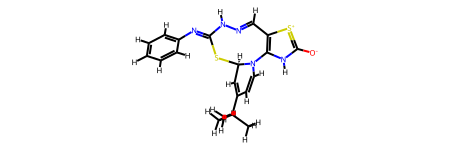

In [11]:
mol1 = pickles[1]['mol']
print(Chem.MolToSmiles(Chem.RemoveHs(mol1), canonical=True, isomericSmiles=False))
mol1

CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1


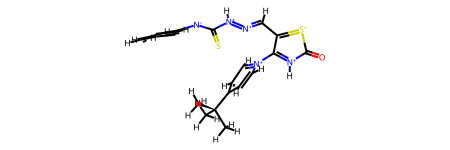

In [12]:
mol2 = pickles[2]['mol']
print(Chem.MolToSmiles(Chem.RemoveHs(mol2), canonical=True, isomericSmiles=False))
mol2

In [13]:
from rdkit.Chem import rdFMCS

# Find maximum common substructure
mcs = rdFMCS.FindMCS([mol1, mol2])
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

# Get matching atom indices
match1 = mol1.GetSubstructMatch(mcs_mol)
match2 = mol2.GetSubstructMatch(mcs_mol)

# Compute RMSD on common atoms
rmsd = AllChem.GetBestRMS(mol1, mol2, map=list(zip(match1, match2)))

print("RMSD on MCS (common substructure):", rmsd)

NameError: name 'AllChem' is not defined

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS

# Load or generate mol1 and mol2 with 3D coordinates
# mol1 = Chem.AddHs(Chem.MolFromSmiles("CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1"))
# mol2 = Chem.AddHs(Chem.MolFromSmiles(smiles2))
AllChem.EmbedMolecule(mol1)
AllChem.EmbedMolecule(mol2)

# Find MCS
mcs_result = rdFMCS.FindMCS([mol1, mol2], completeRingsOnly=True)
mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)

# Match MCS atoms
match1 = mol1.GetSubstructMatch(mcs_mol)
match2 = mol2.GetSubstructMatch(mcs_mol)

if match1 and match2 and len(match1) == len(match2):
    atom_map = list(zip(match1, match2))
    rmsd = AllChem.GetBestRMS(mol1, mol2, map=atom_map)
    print(f"RMSD: {rmsd:.3f} Å")
else:
    print("Cannot compute RMSD: MCS match not found or mismatch in mapping.")


ValueError: sequence does not support length query

In [ ]:
m= 'CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1'
mol_dict = load_pkl(f"/mnt/sxtn2/chem/GEOM_data/rdkit_folder/{drugs_summ[m]['pickle_path']}")
confs = mol_dict['conformers']
for c in confs:
    print(Chem.MolToSmiles(Chem.RemoveHs(c['rd_mol']), canonical=True, isomericSmiles=False))

CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1
CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1
CC(C)(C)c1cc[n+](C2=[NH+]C(=O)[S+]=C2C=[N+]=[NH+]C(=S)[N-]c2ccccc2)cc1
CC(C)(C)C1=CC2SC(=Nc3ccccc3)NN=Cc3[s+]c([O-])[nH]c3N2C=C1


In [14]:
CC(C)(C)c1cc[n+](-c2[nH]c(=O)sc2/C=N/NC([S-])=Nc2ccccc2)cc1	

SyntaxError: invalid syntax (3882298596.py, line 1)